# Text Clustering


## ArXiv Articles: Computation and Language

In [1]:
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

abstracts = list(dataset["Abstracts"])
titles = list(dataset["Titles"])


d:\2026-courses\LLMs-Handson\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\2026-courses\LLMs-Handson\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pc\.cache\huggingface\hub\datasets--maartengr--arxiv_nlp. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer m

In [6]:
print(abstracts[:10])
print(len(abstracts))

['  In this paper Arabic was investigated from the speech recognition problem\npoint of view. We propose a novel approach to build an Arabic Automated Speech\nRecognition System (ASR). This system is based on the open source CMU Sphinx-4,\nfrom the Carnegie Mellon University. CMU Sphinx is a large-vocabulary;\nspeaker-independent, continuous speech recognition system based on discrete\nHidden Markov Models (HMMs). We build a model using utilities from the\nOpenSource CMU Sphinx. We will demonstrate the possible adaptability of this\nsystem to Arabic voice recognition.\n', '  In this paper we present the creation of an Arabic version of Automated\nSpeech Recognition System (ASR). This system is based on the open source\nSphinx-4, from the Carnegie Mellon University. Which is a speech recognition\nsystem based on discrete hidden Markov models (HMMs). We investigate the\nchanges that must be made to the model to adapt Arabic voice recognition.\n  Keywords: Speech recognition, Acoustic mod

In [7]:
print(titles[:10])
print(len(titles))

['Introduction to Arabic Speech Recognition Using CMUSphinx System', 'Arabic Speech Recognition System using CMU-Sphinx4', 'On the Development of Text Input Method - Lessons Learned', 'Network statistics on early English Syntax: Structural criteria', 'Segmentation and Context of Literary and Musical Sequences', 'International Standard for a Linguistic Annotation Framework', 'A Formal Model of Dictionary Structure and Content', 'Practical Approach to Knowledge-based Question Answering with Natural\n  Language Understanding and Advanced Reasoning', 'Learning Probabilistic Models of Word Sense Disambiguation', 'Learning Phonotactics Using ILP']
44949


## A Common Pipeline for Text Clustering
### 1. Embedding Documents

In [4]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(abstracts, convert_to_tensor=True)


W0128 07:22:24.574000 17032 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
d:\2026-courses\LLMs-Handson\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pc\.cache\huggingface\hub\models--thenlper--gte-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-yo

In [8]:
print(embeddings.shape)

torch.Size([44949, 384])


### 2. Reducing the Dimensionality of Embeddigns
 

In [ ]:
from umap import UMAP

# We reduce the input embeddings from 384 dimenions to 5 dimenions
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)


reduced_embeddings = umap_model.fit_transform(embeddings)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

## Why the above error happens
- Our embeddings were likely produced by a model running on GPU (e.g. Sentence Transformers, Hugging Face, etc.).
- UMAP internally calls .numpy()
- PyTorch does NOT allow converting a CUDA tensor directly to NumPy
- Hence the error: TypeError: can't convert cuda:0 device type tensor to numpy

In [15]:
from umap import UMAP

# We reduce the input embeddings from 384 dimenions to 5 dimenions
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
embeddings_cpu = embeddings.detach().cpu().numpy()

reduced_embeddings = umap_model.fit_transform(embeddings_cpu)

d:\2026-courses\LLMs-Handson\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### 3. Cluster the Reduced Embeddings

In [16]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50,
    metric='euclidean',
    cluster_selection_method='eom'
).fit(reduced_embeddings)


In [18]:
clusters = hdbscan_model.labels_
# How many clusters did we generate?
len(set(clusters))

159

In [19]:
hdbscan_model

,min_cluster_size,50
,min_samples,None
,cluster_selection_epsilon,0.0
,cluster_selection_persistence,0.0
,max_cluster_size,0
,metric,'euclidean'
,alpha,1.0
,p,None
,algorithm,'best'
,leaf_size,40
,memory,Memory(location=None)


### Inspecting the clusters

In [20]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



In [21]:
clusters

array([149, 149,  -1, ...,  -1, 151,  -1], shape=(44949,))

Next, we reduce our embeddings to 2-dimensions so that we can plot them and get a rough understanding of the generated clusters.

In [23]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings.detach().cpu().numpy())

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]



d:\2026-courses\LLMs-Handson\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [25]:
df.head()

,x,y,title,cluster
0,4.148614,12.748173,Introduction to Arabic Speech Recognition Usin...,149
1,4.155589,12.740182,Arabic Speech Recognition System using CMU-Sph...,149
2,3.316732,11.936174,On the Development of Text Input Method - Less...,-1
3,1.431549,10.130220,Network statistics on early English Syntax: St...,-1
4,3.845703,7.919153,Segmentation and Context of Literary and Music...,70


## static Plot

(np.float64(-8.423831701278687),
 np.float64(10.948607206344604),
 np.float64(-2.1428836584091187),
 np.float64(18.30795180797577))

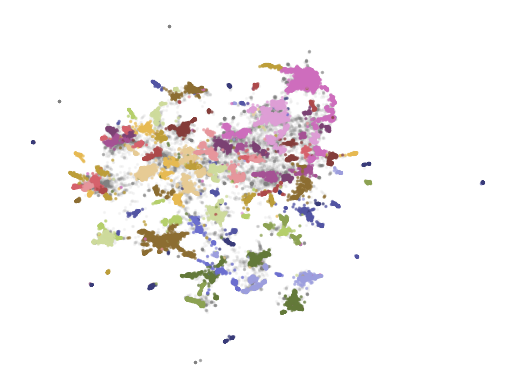

In [24]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.axis('off')
# plt.savefig("matplotlib.png", dpi=300)  # Uncomment to save the graph as a .png

hdbscan_model